# Cargar env

In [54]:
import dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

dotenv.load_dotenv()
llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [32]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="obsidian_jarvis",
    embedding_function=embeddings,
    persist_directory="./obsidian_jarvis_db",  # Where to save data locally, remove if not necessary
)

In [64]:
obsidian_retriever = vector_store.as_retriever()

### Probar vectorstore

In [5]:


results = vector_store.similarity_search_with_score(
    "what can you tell me about langchain?", k=3,
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")


* [SIM=1.065205] Es una herramienta para controlar LLM's, por ejemplo si una LLM se usa para detectar queries de clientes que introducen texto indicando una cancion pero se necesita otra LLM para escribir la respuesta

[[Rag from scratch with langchain]] [{'concepts': 'TEC-PRO', 'id': 101, 'last_modified': '2025-03-03T19:36:13.901802', 'tags': 'Lenguaje de progra', 'title': 'LangChain', 'uuid': '62f34590-740d-4a2b-9c04-523247011b06'}]
* [SIM=1.258643] ### Info:
Retrieval-augmented generation

this is a method to have a data store connected to the LLM in order to review information relevant to the prompt and be able to:
- source the data 
- update the data without retraining the model
- say "i dont know"


### Aprendizaje:
[[Rag from scratch with langchain]] [{'concepts': 'TEC-ML-FOU', 'id': 16, 'last_modified': '2025-03-03T19:31:14.906355', 'tags': 'ML', 'title': 'RAG', 'uuid': 'edeb398a-7f94-4844-a4d9-7bf637e42d09'}]
* [SIM=1.541880] trabajos sobre

## 1. machine learning programming 

# LLM orchestration
## Prompt

In [6]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/luisgg/programacion/git/obsidian_agent/Obsidian_agent/venv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## State

In [7]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Using state - mixing it with functions

In [8]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

### Graph

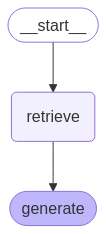

In [9]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Question

In [10]:
result = graph.invoke({"question": "what can you tell me about tecnologies and projectes in the vault?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='e93697c8-c831-4119-a6fe-3a456c5d8f34', metadata={'concepts': 'PER-INF-KM, TEC-SOF, TEC-PRO', 'id': 50, 'last_modified': '2025-03-03T19:33:20.551902', 'tags': 'Estudiar, Software engineering, Examenes de conocimiento, Administración', 'title': 'Posibles proyectos', 'uuid': 'e93697c8-c831-4119-a6fe-3a456c5d8f34'}, page_content='# Software / Profesional\n\n[5 proyectos atractivos](https://www.youtube.com/watch?v=vGxR98gI930&ab_channel=JasonGoodison)\n[Proyectos para hacer segun prime](https://www.youtube.com/watch?v=yeatOU5vVsA&ab_channel=ThePrimeTime)\n## Aplicaciones\n[[InteractionAI]]\n[[Life manager]]\n## Portafolios\n[[Leetcode]]\n## Habilidades\n[[Git y github]]'), Document(id='e4205bdd-4da1-479b-96e2-3206e271f3ea', metadata={'concepts': 'TEC-PRO', 'id': 180, 'last_modified': '2025-03-03T19:40:28.602801', 'tags': 'Trabajo 💼', 'title': 'Remotask', 'uuid': 'e4205bdd-4da1-479b-96e2-3206e271f3ea'}, page_content='[Remotask](https://www.remotasks.com/dashboard) Es l

# Upgrade note:

# Extractor (query analyzer)

In [25]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define a custom prompt to provide instructions and any additional context.
# 1) You can add examples into the prompt template to improve extraction quality
# 2) Introduce additional parameters to take context into account (e.g., include metadata
#    about the document from which the text was extracted.)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from the query "
            "If you do not know the value of an attribute asked "
            "to extract, return null for the attribute's value.",
        ),
        # ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        MessagesPlaceholder("examples"),  # <-- EXAMPLES!
        # ↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        ("human", "{text}"),
    ]
)

In [12]:
from langchain_core.messages import (
    HumanMessage,
)

prompt.invoke(
    {"text": "this is some text", "examples": [HumanMessage(content="testing 1 2 3")]}
)

ChatPromptValue(messages=[SystemMessage(content="You are an expert extraction algorithm. Only extract relevant information from the queryIf you do not know the value of an attribute asked to extract, return null for the attribute's value.", additional_kwargs={}, response_metadata={}), HumanMessage(content='testing 1 2 3', additional_kwargs={}, response_metadata={}), HumanMessage(content='this is some text', additional_kwargs={}, response_metadata={})])

In [18]:
from typing import List, Optional
from typing import List, Optional, Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

TipoOptions = Literal["Resolver duda", "Elaborar un plan de accion", "Realizar una tarea"]
tiempoOptions = Literal["Pasado", "Presente", "Futuro"]
UrgenciaOptions = Literal["baja", "media", "alta", "crítica"]
endgoalOptions = Literal["Desarrollar informacion sobre un tema", "Resolver un problema inmediato"]

class pregunta(BaseModel):
    """Information about a person."""
    tipo: Optional[TipoOptions] = Field(..., description="Que tipo de accion requiere la consulta?")
    urgencia: Optional[UrgenciaOptions] = Field(
        ..., description="Requiere una respuesta inmediata y corta o puede esperar una respuesta mas larga y detallada?"
    )
    tiempo: Optional[tiempoOptions] = Field(..., description="En que tiempo se esta refiriendo, si se consulta informacion pasada o planes para futuro.")
    end_goal: Optional[endgoalOptions] = Field(..., description="Que es lo que se quiere lograr con la consulta?")


In [19]:
import uuid
from typing import Dict, List, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from pydantic import BaseModel, Field


class Example(TypedDict):
    """A representation of an example consisting of text input and expected tool calls.

    For extraction, the tool calls are represented as instances of pydantic model.
    """

    input: str  # This is the example text
    tool_calls: List[BaseModel]  # Instances of pydantic model that should be extracted


def tool_example_to_messages(example: Example) -> List[BaseMessage]:
    """Convert an example into a list of messages that can be fed into an LLM.

    This code is an adapter that converts our example to a list of messages
    that can be fed into a chat model.

    The list of messages per example corresponds to:

    1) HumanMessage: contains the content from which content should be extracted.
    2) AIMessage: contains the extracted information from the model
    3) ToolMessage: contains confirmation to the model that the model requested a tool correctly.

    The ToolMessage is required because some of the chat models are hyper-optimized for agents
    rather than for an extraction use case.
    """
    messages: List[BaseMessage] = [HumanMessage(content=example["input"])]
    tool_calls = []
    for tool_call in example["tool_calls"]:
        tool_calls.append(
            {
                "id": str(uuid.uuid4()),
                "args": tool_call.model_dump(),
                # The name of the function right now corresponds
                # to the name of the pydantic model
                # This is implicit in the API right now,
                # and will be improved over time.
                "name": tool_call.__class__.__name__,
            },
        )
    messages.append(AIMessage(content="", tool_calls=tool_calls))
    tool_outputs = example.get("tool_outputs") or [
        "You have correctly called this tool."
    ] * len(tool_calls)
    for output, tool_call in zip(tool_outputs, tool_calls):
        messages.append(ToolMessage(content=output, tool_call_id=tool_call["id"]))
    return messages

In [37]:
examples = [
    (
        "Quiero aprender sobre matematicas desde donde me habia quedado",
        pregunta(
            tipo="Resolver duda",
            urgencia="baja", 
            tiempo="Presente",
            end_goal="Desarrollar informacion sobre un tema"
        ),
    ),
    (
        "Se puede hacer agua mineral de forma casera?",
        pregunta(
            tipo="Resolver duda",
            urgencia="alta",
            tiempo="Presente", 
            end_goal="Resolver un problema inmediato"
        ),
    ),
    (
        "Necesito que recuerdes esto y lo escribas en una nota nueva",
        pregunta(
            tipo="Realizar una tarea",
            urgencia="alta",
            tiempo="Presente",
            end_goal="Resolver un problema inmediato"
        ),
    ),
    (
        "Quiero que me ayudes a planificar mi proximo viaje a Japon",
        pregunta(
            tipo="Elaborar un plan de accion",
            urgencia="baja",
            tiempo="Futuro",
            end_goal="Desarrollar informacion sobre un tema"
        ),
    ),
    (
        "Am I Cute?",
        pregunta(
            tipo="Resolver duda",
            urgencia="baja",
            tiempo="Presente",
            end_goal="Resolver un problema inmediato"
        ),
    )
]

messages = []

for text, tool_call in examples:
    messages.extend(
        tool_example_to_messages({"input": text, "tool_calls": [tool_call]})
    )


In [26]:
example_prompt = prompt.invoke({"text": "this is some text", "examples": messages})

for message in example_prompt.messages:
    print(f"{message.type}: {message}")

system: content="You are an expert extraction algorithm. Only extract relevant information from the query If you do not know the value of an attribute asked to extract, return null for the attribute's value." additional_kwargs={} response_metadata={}
human: content='Quiero aprender sobre matematicas desde donde me habia quedado' additional_kwargs={} response_metadata={}
ai: content='' additional_kwargs={} response_metadata={} tool_calls=[{'name': 'pregunta', 'args': {'tipo': 'Resolver duda', 'urgencia': 'baja', 'tiempo': 'Presente', 'end_goal': 'Desarrollar informacion sobre un tema'}, 'id': '471f3689-76e5-439f-9b47-74c1352bbcd9', 'type': 'tool_call'}]
tool: content='You have correctly called this tool.' tool_call_id='471f3689-76e5-439f-9b47-74c1352bbcd9'
human: content='Se puede hacer agua mineral de forma casera?' additional_kwargs={} response_metadata={}
ai: content='' additional_kwargs={} response_metadata={} tool_calls=[{'name': 'pregunta', 'args': {'tipo': 'Resolver duda', 'urgen

In [27]:
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
load_dotenv()

llm = init_chat_model("gpt-4-0125-preview", model_provider="openai", temperature=0)

In [28]:
runnable = prompt | llm.with_structured_output(
    schema=pregunta,
    method="function_calling",
    include_raw=False,
)

In [29]:
for _ in range(5):
    text = "quiero investigar sobre langchain y necesito tu ayuda"
    print(runnable.invoke({"text": text, "examples": messages}))

tipo='Resolver duda' urgencia='media' tiempo='Presente' end_goal='Desarrollar informacion sobre un tema'
tipo='Resolver duda' urgencia='media' tiempo='Presente' end_goal='Desarrollar informacion sobre un tema'
tipo='Resolver duda' urgencia='media' tiempo='Presente' end_goal='Desarrollar informacion sobre un tema'
tipo='Resolver duda' urgencia='media' tiempo='Presente' end_goal='Desarrollar informacion sobre un tema'
tipo='Resolver duda' urgencia='media' tiempo='Presente' end_goal='Desarrollar informacion sobre un tema'


In [38]:
runnable.invoke(
    {
        "text": "Am I cute?",
        "examples": messages,
    }
)

pregunta(tipo='Resolver duda', urgencia='baja', tiempo='Presente', end_goal='Resolver un problema inmediato')

# Analizador de notas (extraction)

In [40]:


results = vector_store.similarity_search_with_score(
    "what can you tell me about langchain?", k=5,
)

print(results)

#for res, score in results:
#    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]")


[(Document(id='62f34590-740d-4a2b-9c04-523247011b06', metadata={'concepts': 'TEC-PRO', 'id': 101, 'last_modified': '2025-03-03T19:36:13.901802', 'tags': 'Lenguaje de progra', 'title': 'LangChain', 'uuid': '62f34590-740d-4a2b-9c04-523247011b06'}, page_content="Es una herramienta para controlar LLM's, por ejemplo si una LLM se usa para detectar queries de clientes que introducen texto indicando una cancion pero se necesita otra LLM para escribir la respuesta\n\n[[Rag from scratch with langchain]]"), 1.0652047395706177), (Document(id='edeb398a-7f94-4844-a4d9-7bf637e42d09', metadata={'concepts': 'TEC-ML-FOU', 'id': 16, 'last_modified': '2025-03-03T19:31:14.906355', 'tags': 'ML', 'title': 'RAG', 'uuid': 'edeb398a-7f94-4844-a4d9-7bf637e42d09'}, page_content='### Info:\nRetrieval-augmented generation\n\nthis is a method to have a data store connected to the LLM in order to review information relevant to the prompt and be able to:\n- source the data \n- update the data without retraining the m

# Final pipeline

In [49]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults

In [56]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    VaultFindings: Document
    Query_results: pregunta
    webfindings: Document

In [62]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    VaultFindings: str, Web_results: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": VaultFindings,
            "birthday": Web_results,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_documents = VaultFindings
        verified_search_data = Web_results
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_documents = human_response.get("name", VaultFindings)
        verified_search_data = human_response.get("birthday", Web_results)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_documents,
        "birthday": verified_search_data,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [65]:
obsidian_retriever = vector_store.as_retriever(
    search_kwargs={"k": 5}
)

In [66]:

@tool
def extract_vault_data(
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Extract data from vault findings and prepare for updates."""
    # This tool doesn't need parameters since it reads from state
    
    # Return a Command to update the state
    return Command(update={
        "messages": [ToolMessage("Vault data processed successfully", tool_call_id=tool_call_id)]
    })

In [67]:
# Define a node function that processes vault documents
def vault_processor(state: State):
    """Node to process retrieved vault documents and extract relevant information."""
    # Extract documents from state
    vault_findings = state.get("VaultFindings", [])
    query_intent = state.get("Query_results", {})
    
    # Process documents - here we're keeping it simple as you requested
    processed_docs = []
    
    for doc in vault_findings:
        # Extract key information
        uuid = doc.metadata.get("uuid", "")
        title = doc.metadata.get("title", "Untitled")
        content = doc.page_content
        
        # Store in a simple dict
        processed_docs.append({
            "uuid": uuid,
            "title": title,
            "content": content,
            "metadata": doc.metadata
        })
    
    # Return updated state
    return {
        "processed_vault_docs": processed_docs,
        "primary_doc": processed_docs[0] if processed_docs else None
    }

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


webtool = TavilySearchResults(max_results=7)
tools = [webtool, human_assistance, extract_vault_data]  # Add the new tool
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("vault_processor", vault_processor)  # Add vault processor node

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


In [ ]:
# Define a condition to route to vault processor when we have vault findings
def should_process_vault(state):
    """Route to vault processor if we have VaultFindings."""
    if state.get("VaultFindings"):
        return "vault_processor"
    return "chatbot"

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_conditional_edges(
    "tools",
    should_process_vault,
)
graph_builder.add_edge("vault_processor", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [ ]:

from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


webtool = TavilySearchResults(max_results=7)
tools = [webtool, human_assistance]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [69]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3WENbvzlrtsiRD6kfbM1gbqr)
 Call ID: call_3WENbvzlrtsiRD6kfbM1gbqr
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Releases · langchain-ai/langgraph - GitHub", "url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph · GitHub Search code, repositories, users, issues, pull requests... Releases: langchain-ai/langgraph Releases · langchain-ai/langgraph langgraph: release 0.2.70 (#3341) langgraph: add agent name to AI messages in create_react_agent (#3340) fix(langgraph): Dedupe input (right-side) messages

In [60]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_Uu8FKy9U09bHUTLTXerAFdf5)
 Call ID: call_Uu8FKy9U09bHUTLTXerAFdf5
  Args:
    name: LangGraph
    birthday: 2025-02-06
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

The release date of LangGraph is January 17, 2024.


In [68]:
# Add this right after your human_assistance tool, where you indicated

@tool
def extract_vault_data(
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Extract data from vault findings and prepare for updates."""
    # This tool doesn't need parameters since it reads from state
    
    # Return a Command to update the state
    return Command(update={
        "messages": [ToolMessage("Vault data processed successfully", tool_call_id=tool_call_id)]
    })

# Define a node function that processes vault documents
def vault_processor(state: State):
    """Node to process retrieved vault documents and extract relevant information."""
    # Extract documents from state
    vault_findings = state.get("VaultFindings", [])
    query_intent = state.get("Query_results", {})
    
    # Process documents - here we're keeping it simple as you requested
    processed_docs = []
    
    for doc in vault_findings:
        # Extract key information
        uuid = doc.metadata.get("uuid", "")
        title = doc.metadata.get("title", "Untitled")
        content = doc.page_content
        
        # Store in a simple dict
        processed_docs.append({
            "uuid": uuid,
            "title": title,
            "content": content,
            "metadata": doc.metadata
        })
    
    # Return updated state
    return {
        "processed_vault_docs": processed_docs,
        "primary_doc": processed_docs[0] if processed_docs else None
    }

# Now, modify your graph to include this node
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


webtool = TavilySearchResults(max_results=7)
tools = [webtool, human_assistance, extract_vault_data]  # Add the new tool
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("vault_processor", vault_processor)  # Add vault processor node

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Define a condition to route to vault processor when we have vault findings
def should_process_vault(state):
    """Route to vault processor if we have VaultFindings."""
    if state.get("VaultFindings"):
        return "vault_processor"
    return "chatbot"

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_conditional_edges(
    "tools",
    should_process_vault,
)
graph_builder.add_edge("vault_processor", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)